In [13]:
from tensorboard.backend.event_processing import event_accumulator
import os
from typing import List, Tuple
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def read_values(event_path: str) -> List[float]:
    ea = event_accumulator.EventAccumulator(event_path)
    ea.Reload()

    values = [e.value for e in ea.Scalars('loss')]

    return values


def read_train_val_loss(ht_dir_path: str) -> Tuple[List[float], List[float]]:
    loss_train_dir = os.path.join(ht_dir_path, 'loss_train')
    loss_val_dir = os.path.join(ht_dir_path, 'loss_val')

    train_event_filename = os.listdir(loss_train_dir)[0]
    val_event_filename = os.listdir(loss_val_dir)[0]

    train_event_filepath = os.path.join(loss_train_dir, train_event_filename)
    val_event_filepath = os.path.join(loss_val_dir, val_event_filename)

    return read_values(train_event_filepath), read_values(val_event_filepath)


def extract_H_T(H_T_dirname: str) -> Tuple[int,int]:
    h,t = H_T_dirname.split('-')

    return int(h[1:]), int(t[1:])


def analyse(exp_dir: str ='exp', model: str ='dlinear', data: str ='1d'):
    data_dir = os.path.join(exp_dir, model, data)

    h = []
    t = []
    val_mse = []
    train_mse = []

    for ht_dir_name in os.listdir(data_dir):
        ht_dir_path = os.path.join(data_dir, ht_dir_name)
        H,T = extract_H_T(ht_dir_name)

        train_losses, val_losses = read_train_val_loss(ht_dir_path)

        h.append(H)
        t.append(T)
        val_mse.append(np.mean(val_losses))
        train_mse.append(np.mean(train_losses))

    df = pd.DataFrame({
        'H': h,
        'T': t,
        'val_mse': val_mse,
        'train_mse': train_mse
    })

    sns.scatterplot(df, x='H', y='T', size='val_mse', sizes=(20,200), legend=False)
    plt.show()

    df.sort_values(by='T')
    sns.catplot(df, x='H', y='val_mse', hue='T', kind='bar', palette='rocket')
    plt.show()
    

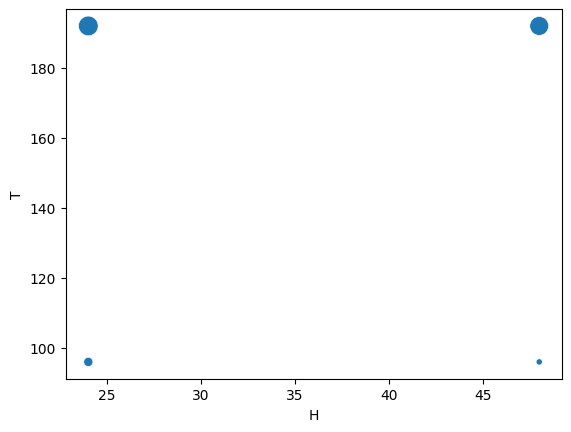

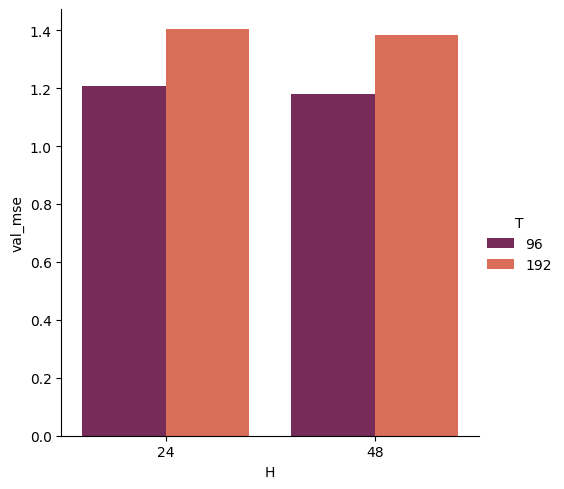

In [50]:
analyse()